In [1]:
suppressMessages(library(dplyr))
suppressMessages(library(gprofiler2))
suppressMessages(library(pheatmap))
suppressMessages(library(ggplot2))
suppressMessages(library(RColorBrewer))
source('trio_analysis_helper.R')

In [2]:
output_dir <- '../../analysis/real_data/output'

In [3]:
trio_pval_cutoff_vec <- c(0.001)
names(trio_pval_cutoff_vec) <- c('CD14 Mono')

In [4]:
trios_list <- load_trios_list(2000, 'CD14 Mono', 'PBMC_4_combined', trio_pval_cutoff_vec['CD14 Mono'], output_dir)
res <- summarize_enr(trios_list, p_top = 10)

[1] "ZEB1"
[1] "BACH2"
[1] "LEF1"
[1] "ETS1"
[1] "TCF7"
[1] "RORA"
[1] "KLF4"
[1] "SPI1"
[1] "KLF2"
[1] "NR3C2"


In [5]:
enrich_matrix <- make_pheatmap(res)
# immune-related terms
#selected_terms <- c(2,5,11,16,18,
#               22,24,27,30,33,35,39,48,54,55,64,65,72)
selected_terms <- c(2,4,11,26,29,31,33,44,52,53,71)
rownames(enrich_matrix[selected_terms,])
sum_enr <- enrich_matrix[selected_terms,]

[1] "antigen processing and presentation of peptide or polysaccharide antigen via MHC class II"
 [2] "immune response"                                                                          
 [3] "regulation of immune system process"                                                      
 [4] "T cell activation"                                                                        
 [5] "integrated stress response signaling"                                                     
 [6] "regulation of immune response"                                                            
 [7] "leukocyte chemotaxis"                                                                     
 [8] "immune system process"                                                                    
 [9] "regulation of lymphocyte activation"                                                      
[10] "dendritic cell antigen processing and presentation"                                       
[11] "immune response-regulating signaling pathway"

In [6]:
# if we want to explore putting GO term names on the left
# https://stackoverflow.com/questions/57729914/how-can-you-show-the-rownames-in-pheatmap-on-the-left-side-of-the-graph
repr.plot.ratio <- 1.35
options(repr.plot.width = 6.5 * repr.plot.ratio, repr.plot.height=3.5 * repr.plot.ratio)

# max(enrich_matrix) as upper limit: too large to see other items
int_enr_sum <- sum_enr[,!colSums(sum_enr) == 0]
int_enr_sum <- int_enr_sum[apply(int_enr_sum,1,max) > -log10(0.05),] # filter by adjusted p value < 0.05
rownames(int_enr_sum)[1] <- 'antigen processing and presentation of peptide \nor polysaccharide antigen via MHC class II'

# filter weak terms
int_enr_sum <- int_enr_sum[apply(int_enr_sum,1,max) > 5,]
# filter TFs with no relevant enrichment
int_enr_sum <- int_enr_sum[,colSums(int_enr_sum) > 0]


g <- pheatmap(int_enr_sum,#enrich_matrix[,colSums(enrich_matrix!=0) > 2],
              col = c('white', brewer.pal(9, 'Reds')),
              cluster_rows = F, cluster_cols = F,
              annotation_names_row = F, 
              annotation_names_col = F,
              fontsize_row = 15,          # row label font size
              fontsize_col = 15,          # column label font size
              angle_col = 45, # sample names at an angle
              show_colnames = T, show_rownames = T, # displaying column and row names
              silent=T,
              fontsize = 15,
              border_color  = NA, cellwidth=23) 

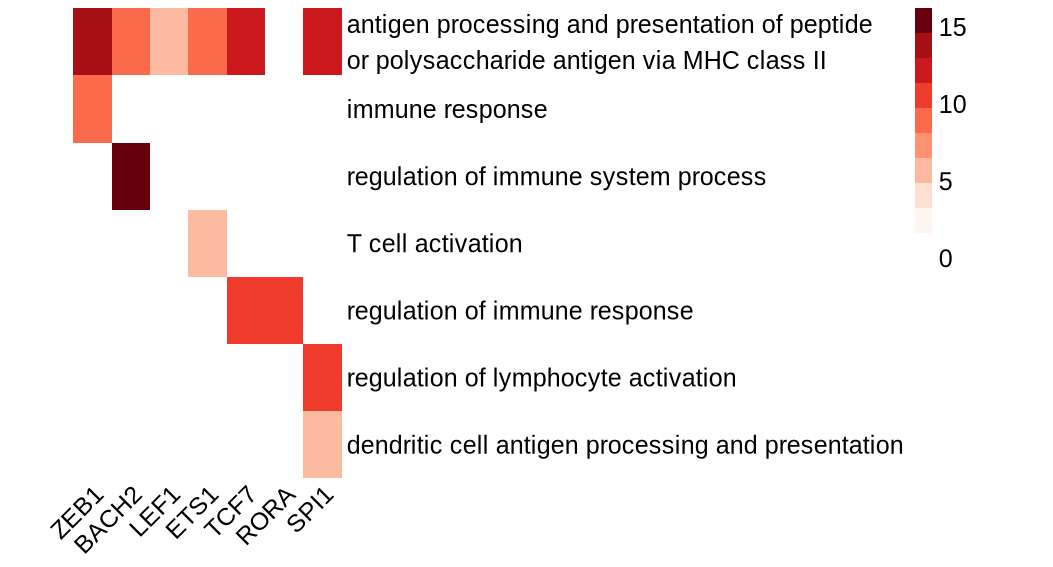

In [7]:
g

In [8]:
write.table(int_enr_sum, '../manuscript/Source Data/main/figure_2c.txt')

In [9]:
ggsave(sprintf('../manuscript/figures/%s_2000_pval_0.001.pdf', 'CD14 Mono'), g,
       width = 7 * repr.plot.ratio, height = 3 * repr.plot.ratio)

# Supplementary analysis 
Comparison with Signac and SCENT

First, generate Signac and SCENT's results on peak-TF pairs by 

```{bash}
####################################
# 1. get candidate TF-peak pairs
####################################
Rscript get_trio_peak_TF_pairs.R

####################################
# 2. run Signac
####################################
Rscript run_Signac-checkpoint.R \
    --i_ct=1 \
    --study=PBMC_4_combined \
    --permu_within_batch=FALSE \
    --run_TF_peak=TRUE
for i in {1..100}
do
    Rscript run_Signac-checkpoint.R \
        --i_ct=1 \
        --study=PBMC_4_combined \
        --permu_within_batch=TRUE \
        --i_permu=$i \
        --run_TF_peak=TRUE
done
# adjust Signac's results by permutation
Rscript adjust_Signac.R --i_ct=1 --study=PBMC_4_combined --run_TF_peak=TRUE

####################################
# 3. run SCENT
####################################
for i in {1..10}
do
    Rscript run_SCENT.R \
    --ct="CD14 Mono" \
    --study="PBMC_4_combined" \
    --i_set=$i \
    --n_sets=10 \
    --n_bootstrap=5000 \
    --adjust_for_batch=TRUE \
--run_TF_peak=TRUE
done
```

## 2. Construct trios

The codes below were modified from construct_trios.R for the analysis on scMultiMap's results.

In [10]:
suppressMessages(library(dplyr))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(JASPAR2020))
source('reproducibility_helper.R')

study <- 'PBMC_4_combined'
ct <- 'CD14 Mono'
pairs_suffix <- ''
pair_sigp_cutoff <- 0.001

In [11]:
preprocess_output_dir <- '../../analysis/preprocessing/output'
fig_dir <- '../../analysis/manuscript/figures'

In [12]:
#############
# load TF data
#############
# load seurat object
pre_dir <- sprintf('%s/%s/%s', preprocess_output_dir, study, ct)
obj_suffix <- ''
# load data - generated by preprocessing/save_seurat_obj_by_ct.R
ct_obj <- readRDS(sprintf('%s_seurat_obj%s.rds', pre_dir, obj_suffix))

# load motif info
if(grepl('PBMC', study)){
    DefaultAssay(ct_obj) <- 'peaks_ct'
    motif.object <- readRDS(sprintf('%s/%s/motif.object.rds', preprocess_output_dir, study))
}else if(grepl('brain', study)){
    motif.object <- readRDS('%s/%s/motif.object.rds', preprocess_output_dir, stud)
}
Motifs(ct_obj) <- motif.object
# extract all TF names from JASPAR 2020 database
full_TF_names <- ConvertMotifID(ct_obj, id = colnames(motif.object@data))

#############
# load peak-gene pair results
#############
res_list <- list()
res_list[['Signac']] <- load_Signac(ct, datasets = 'PBMC_4_combined',
                                    fn_suffix = '_permu_adjusted',
                                   output_dir = output_dir)[[1]]
res_list[['SCENT']] <- load_SCENT(ct, n_sets=10,
                                  datasets = 'PBMC_4_combined',
                                 '_batch_as_covar_adjusted_n_bootstrap_5000',
                                 output_dir = output_dir)[[1]]
res_list[['proposed']] <- load_proposed(ct, study, sprintf('%s_batch_adjusted', pairs_suffix),
                                       output_dir = output_dir)[[1]]


#############
# load target gene-TF results
#############
# use co-expression results from CS-CORE
TF_coexp_list <- readRDS(sprintf('%s_TF_gene_coexp%s.rds', sprintf('%s/%s/%s', output_dir, study, ct),
                       sprintf('%s_batch_adjusted', pairs_suffix)))
TF_target_p <- TF_coexp_list$pval

#############
# extract enriched TFs
#############
p_var <- 'pval'
p_cutoff <- 0.05
sig_inds_list <- which(res_list[['proposed']][[p_var]] < p_cutoff)
print(length(sig_inds_list))

linked_peaks <- res_list[['proposed']]$peak[sig_inds_list]
sparsity <- TF_coexp_list[[3]]
TF_enrich_list <- TF_motif_enrich(linked_peaks, sparsity, ct_obj)

#############
# load TF-peak results for Signac and SCENT
#############
TF_peak_df_list <- list()
# Signac
TF_peak_df_list[['Signac']] <- load_Signac(ct, datasets = 'PBMC_4_combined',
                                           fn_suffix = '_permu_adjusted_TF_peak',
                                          output_dir = output_dir)[[1]]
# SCENT
TF_peak_df_list[['SCENT']] <- load_SCENT(ct, n_sets=10,
                                      datasets = 'PBMC_4_combined',
                                      '_batch_as_covar_adjusted_n_bootstrap_5000_TF_peak',
                                        output_dir = output_dir)[[1]]

sum(TF_peak_df_list[['SCENT']]$pval < pair_sigp_cutoff)
sum(TF_peak_df_list[['Signac']]$pval < pair_sigp_cutoff, na.rm=T) # lower power

# split results by TFs
TF_peak_list <- list()
for(method in names(TF_peak_df_list)){
    tmp <- list()
    for(TF in unique(TF_peak_df_list[[method]]$gene)){
        tmp[[TF]] <- TF_peak_df_list[[method]][TF_peak_df_list[[method]]$gene == TF,]
        rownames(tmp[[TF]]) <- tmp[[TF]]$peak
    }
    TF_peak_list[[method]] <- tmp
}

[1] 6472


Selecting background regions to match input sequence characteristics

Matching GC.percent distribution

Testing motif enrichment in 6472 regions



[1] 1688

[1] 298

In [13]:
# load all TFs and TF-peak pairs, pre-evaluated in run_proposed.R
TF_peak <- readRDS(sprintf('%s/%s/%s_TF_peak_coexp%s.rds', output_dir, study, ct, sprintf('%s_batch_adjusted', pairs_suffix)))
pair_sigp_cutoff <- 0.001

# The following codes are also used get_trio_peak_TF_pairs-checkpoint.R for 
# pre-filtering peak-TF pairs with significant peak-gene and gene-TF links
TF_peak_sub_list <- list()
TF_trios_df_list <- list()
for(method in c('Signac', 'SCENT')){
    trios_df_list <- list()
    for(TF in names(TF_peak)){
        results <- res_list[[method]]
        peaks_w_binding_motifs <- names(which(motif.object@data[,full_TF_names == TF] != 0))
        results_peaks_w_motif_inds <- results$peak %in% peaks_w_binding_motifs
        # from peak to gene
        peak_gene_pval <- results$pval[results_peaks_w_motif_inds]
        # from gene to TF
        gene_TF_pval <- TF_target_p[TF, results$gene][results_peaks_w_motif_inds]
        trio_inds <- which((peak_gene_pval < pair_sigp_cutoff) & (gene_TF_pval < pair_sigp_cutoff))
        if(length(trio_inds) > 0 & !is.null(TF_peak_list[[method]][[TF]])){
            peak_TF_pval <- TF_peak_list[[method]][[TF]]$pval[match(results$peak[results_peaks_w_motif_inds][trio_inds],
                                                             TF_peak_list[[method]][[TF]]$peak)]
        
            tmp <- results[results_peaks_w_motif_inds, c('peak','gene','pval')][trio_inds,]
            colnames(tmp)[colnames(tmp) == 'pval'] <- 'pval_peak_gene'
            tmp$pval_TF_gene <- gene_TF_pval[trio_inds]
            tmp$pval_peak_TF <- peak_TF_pval
            tmp$TF <- TF
            tmp <- tmp[which(tmp$pval_peak_TF < pair_sigp_cutoff), ] # ifelse(method == 'SCENT', pair_sigp_cutoff*5, pair_sigp_cutoff))
            trios_df_list[[TF]] <- tmp
        }
    }
    TF_trios_df_list[[method]] <- do.call(rbind, trios_df_list)
}

## 3. Evaluate GO enrichment

In [14]:
selected_terms_list <- list()

In [15]:
enr_list <- list()
enr_list[['Signac']] <- summarize_enr(TF_trios_df_list[['Signac']], p_top = 10)
dim(enr_list[['Signac']])
selected_terms_list[['Signac']] <- c(3,17,19,23,26,27,29,34,45,46,53,64,65,68,71)

[1] "KLF4"
[1] "KLF2"
[1] "KLF6"
[1] "RUNX3"
[1] "JUN"
[1] "TCF7L2"
[1] "ATF3"
[1] "SPI1"
[1] "KLF10"
[1] "FOSL1"


[1] 82 16

In [16]:
enr_list[['SCENT']] <- summarize_enr(TF_trios_df_list[['SCENT']], p_top = 10)
dim(enr_list[['SCENT']])
selected_terms_list[['SCENT']] <- c(1,11,19,20,27,28,36,43,45,51,52,62,63,75)
#c(1,11,19,44,51,52,58,68,69,75,76)

[1] "KLF2"
[1] "ZEB1"
[1] "ETS1"
[1] "SPI1"
[1] "JUN"
[1] "TCF7"
[1] "LEF1"
[1] "NFATC2"
[1] "FOXP1"
[1] "RORA"


[1] 100  16

In [17]:
enr_list[['proposed']] <- res
selected_terms_list[['proposed']] <- selected_terms

In [18]:
enrich_matrix_list <- list()
for(method in names(enr_list)){
    enrich_matrix_list[[method]] <- make_pheatmap(enr_list[[method]])
}
sapply(enrich_matrix_list, dim)

Signac,SCENT,proposed
73,77,75
9,10,10


In [19]:
method <- 'SCENT'
enrich_matrix_list[[method]] <- make_pheatmap(enr_list[[method]])

## 4. Compare the results

In [20]:
# share similar terms
for(method in c('Signac', 'SCENT')){
    print(sum(rownames(enrich_matrix_list[['proposed']])[selected_terms_list[['proposed']]] %in% 
              rownames(enrich_matrix_list[[method]])[selected_terms_list[[method]]]))
}

[1] 1
[1] 4


In [21]:
# compare magnitude of enrichment
nonzero_enr <- lapply(enrich_matrix_list, function(m) m[m!=0])

names(nonzero_enr)
names(nonzero_enr) <- c('Signac', 'SCENT', 'scMultiMap')

options(repr.plot.width = 8, repr.plot.height=6)

pdf(sprintf('%s/trio/enr_comp.pdf', fig_dir), width = 8, height = 6)
                      par(cex = 1.5)
boxplot(nonzero_enr, main = '-log10 p-value of enriched GO terms')  
                    
dev.off()

[1] "Signac"   "SCENT"    "proposed"

png 
  2

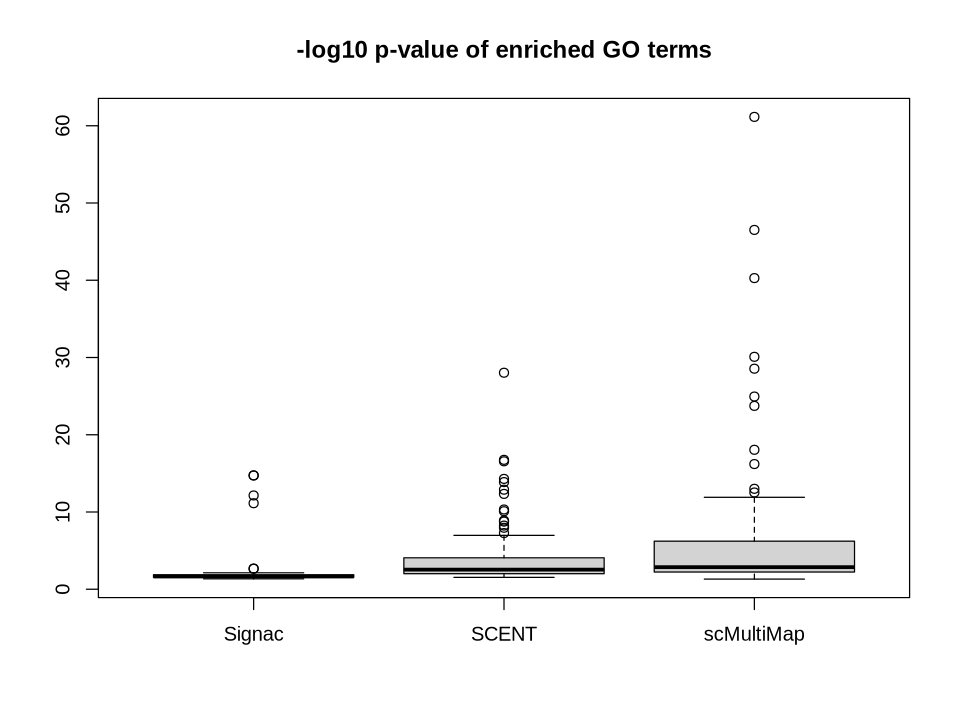

In [22]:
boxplot(nonzero_enr, main = '-log10 p-value of enriched GO terms')  
saveRDS(nonzero_enr, '../manuscript/Source Data/supplementary/figure_7a.rds')

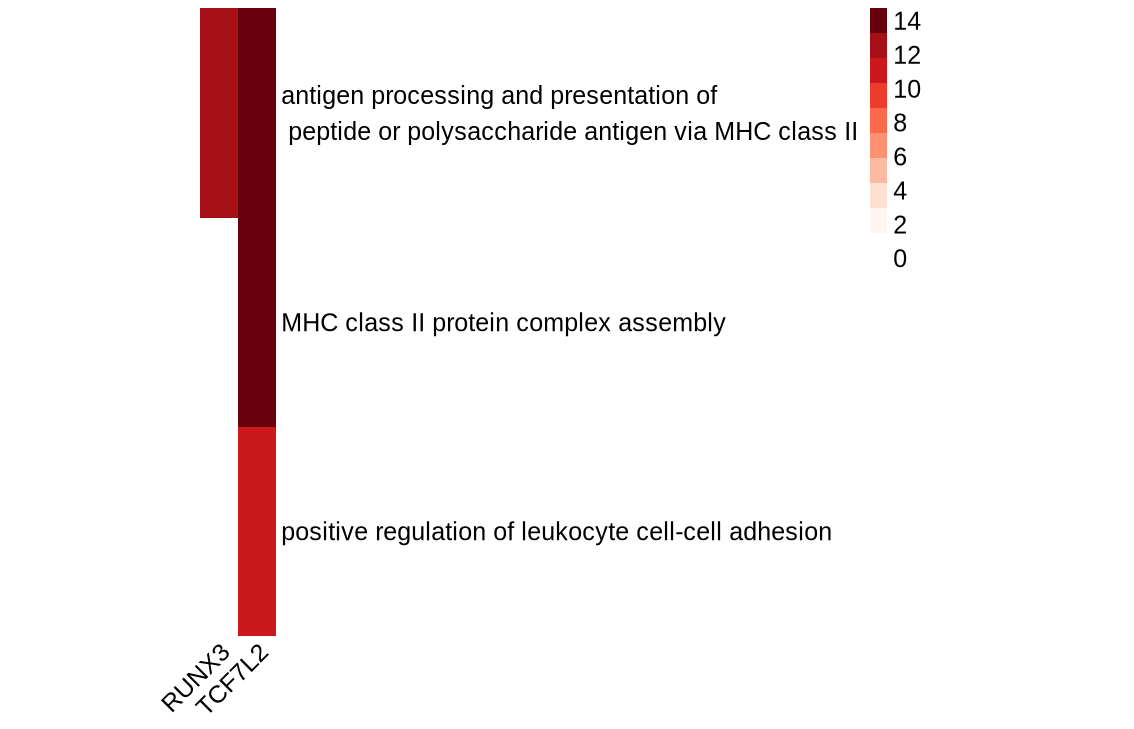

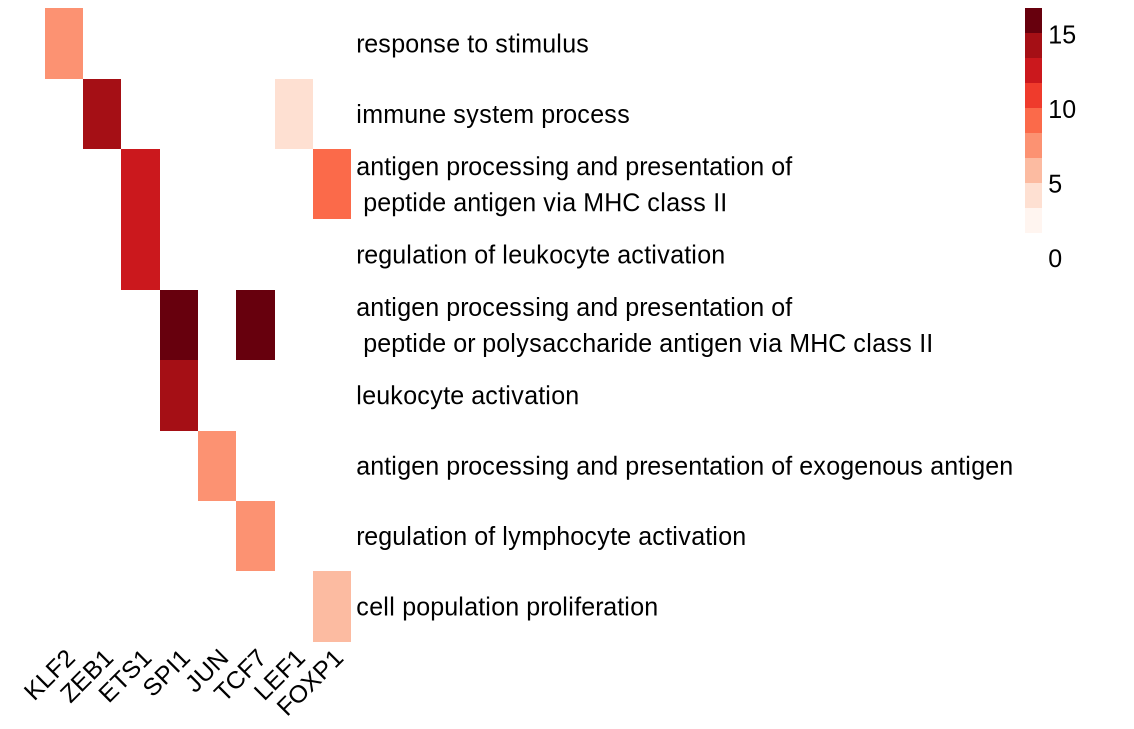

In [23]:
repr.plot.ratio <- 1.35
options(repr.plot.width = 7 * repr.plot.ratio, repr.plot.height=4.5 * repr.plot.ratio)

for(method in c('Signac', 'SCENT')){
    int_enr_sum <- enrich_matrix_list[[method]][selected_terms_list[[method]],, drop=F]
    for(long_term in c('antigen processing and presentation of peptide antigen via MHC class II',
                       'antigen processing and presentation of peptide or polysaccharide antigen via MHC class II',
                      'antigen processing and presentation of exogenous peptide antigen via MHC class II')){
        long_term_ind <- rownames(int_enr_sum) == long_term
        if(any(long_term_ind)){
            rownames(int_enr_sum)[long_term_ind] <- sprintf( 'antigen processing and presentation of\n%s',
                                                           gsub('antigen processing and presentation of', '', long_term))
        }
    }
    # filter weak terms
    int_enr_sum <- int_enr_sum[apply(int_enr_sum,1,max) > 5,]
    # filter TFs with no relevant enrichment
    int_enr_sum <- int_enr_sum[,colSums(int_enr_sum) > 0]
    g <- pheatmap(int_enr_sum,
            col = c('white', brewer.pal(9, 'Reds')),
            cluster_rows = F, cluster_cols = F,
                      annotation_names_row = F, 
                      annotation_names_col = F,
                      fontsize_row = 15,          # row label font size
                      fontsize_col = 15,          # column label font size 
                      angle_col = 45, # sample names at an angle
                      #legend_breaks = seq(0, 5, 5/8),# legend customisation
                      #legend_labels = c("Low", "Medium", "High"), # legend customisation
                      show_colnames = T, show_rownames = T, # displaying column and row names
                      #main = ct,
         #annotation_row    = term_ct_label,
         fontsize = 15,
        border_color  = NA, cellwidth=23) 
g
    ggsave(sprintf('%s/trio/%s_2000_pval_0.05_%s.pdf', fig_dir, ct, method), g, 
           width = 7 * repr.plot.ratio, height = 4 * repr.plot.ratio)
    write.table(int_enr_sum, sprintf('../manuscript/Source Data/supplementary/figure_7%s.txt',
                                    ifelse(method == 'Signac', 'b', 'c')))
}